In [1]:
from muselsl import stream, list_muses, view, record
from multiprocessing import Process
from mne import Epochs, find_events
from time import time, strftime, gmtime
import os
from utils import utils
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

# Cueing

This notebook is slightly different than the PC notebooks due to differences in the Mac operating system.

First setup the computer by following the instructions in the mac_instructions_cueing.docx file, then return to this file.

The cueing task can ellicit a number of reliable changes. A central cue indicates the location of an upcoming target onset. Here the task can be changed to be perfectly predictive, or have some level of cue validity. Task is to indicate the orientation of a spatial grating on the target, up for vertical, right for horizontal.  

ERP - Validly cued targets ellict larger ERP's than invalidly cued targets

Response ERPs - Validly cued targets are more quickly identified and better identified

Oscillations - Alpha power lateralizes after a spatial cue onset preceeding the upcoming onset of a target. Alpha power becomes smaller contraleral to the target side, and larger ipsilateral with the target. 

## Step 1: Connect to an EEG Device

Make sure your device is turned on and run the following code. It should detect and connect to the device and begin 'Streaming...'

If the device is not found or the connection times out, try running this code again

If an error occurs scroll down, if it says BGAPIError, check that the black BLE dongle is pluged into the USB port, unplug the black BLE dongle and plug it back in again, then try again.

In [5]:
# Search for available Muse devices
# muses = list_muses()
muses = list_muses()
print(muses)

Searching for Muses, this may take up to 10 seconds...
Found device Muse-1E65, MAC Address 00:55:DA:B0:1E:65
[{'address': '00:55:DA:B0:1E:65', 'name': 'Muse-1E65', 'rssi': -55, 'packet_data': {'connectable_advertisement_packet': {'flags': bytearray(b'\x06'), 'complete_local_name': 'Muse-1E65', 'incomplete_list_16-bit_service_class_uuids': bytearray(b'\x8d\xfe'), 'slave_connection_interval_range': bytearray(b'\x18\x00\x18\x00'), 'tx_power_level': bytearray(b'\x05')}, 'scan_response_packet': {}}}]


Now, choose the Muse you want to connect to. Check the ID on the side of your Muse device, and find the matching device in the list above and define the appropriate index in the my_muse_index variable. That is, if your Muse device is the first device listed above, the index is 1, if it is third in the list, the index is 3, etc.

If the connection is successful, the output will be:

`Connected to Muse: [your_muse_id]`  
`Connected`  
`Streaming ...`  


If this doesn't work, try re-running the cell. You might also need to re-run the cell above. Just keep trying- it will work eventually! Sometimes it just takes time for the connection to be established.

In [7]:
# Start a background process that will stream data from the first available Muse
# if the connection fails, run the list_muses cell above again

my_muse_index = 1

stream_process = Process(target=stream, args=(muses[my_muse_index-1]['address'],))
stream_process.start()

Connecting to Muse : 00:55:DA:B0:1E:65...
Connected.
Streaming...
missing sample 0 : 65535


## Step 2: Apply the EEG Device and Wait for Signal Quality to Stabilize
Open a new terminal by typing "command" + "T" at the same time.

Run the following to start the viewer and see the raw EEG data stream.

`source activate nbmac`   
`muselsl view`

The numbers on the side of the graph indicate the variance of the signal. Wait until this decreases below 10 for all electrodes before proceeding.

## Step 3: Run the Experiment

!!!MAKE SURE THE VOLUME IS ON AND TURNED UP TO FULL!!!

Modify the variables in the following code chunk to define how long you want to run the experiment (# of seconds) and the name of the subject and session you are running. 

Once you run the cell below, open a new terminal and run the following:

`cd ~/eeg-notebooks/notebooks`  
`source activate nbmac`

Then, paste the output from the cell below into the terminal and press `Enter`. This is the command to start the experiment, so make sure that the participant is seated in front of the computer at this point. Then have them quietly view the screen until the experiment is completed and do their best to minimize movement that might contaminate the signal. With their jaw and face relaxed, subjects should look directly at the flashing stimuli.

Data will be recorded into CSV files in the `eeg-notebooks/data/visual/cueing` directory

Here is an example of the experiment command for an cueing experiment that will last 120 seconds, for subject 1 and session 1: 

`python mac_run_exp.py --d 120 --s 1 --r 1 --e cueing`

In [9]:
# Define these parameters 
duration = 240
subject = 100
session = 1
experiment = 'cueing'

# paste the output of this cell into the terminal
cmd2run = 'python mac_run_exp.py --d ' + str(duration) + ' --s ' + str(subject) + ' --r ' + str(session) + ' --e ' + experiment
print(cmd2run)


python mac_run_exp.py --d 240 --s 100 --r 1 --e cueing


### Repeat Data Collection 2 times

Visualizing the effects can sometimes take many rounds of stimulus presentation. Depending on experimental conditions, this may require as little as one two minute trial or as many as 6. We recommend repeating the above experiment 2 times before proceeding. 

Make sure to take breaks, though! Inattention, fatigue, and distraction will decrease the quality of potentials such as the SSVEP

## Step 4: Prepare the Data for Analysis

Once a suitable data set has been collected, it is now time to analyze the data and see if we can identify the cueing effects


### Load data into MNE objects

[MNE](https://martinos.org/mne/stable/index.html) is a very powerful Python library for analyzing EEG data. It provides helpful functions for performing key tasks such as filtering EEG data, rejecting artifacts, and grouping EEG data into chunks (epochs).

The first step after loading dependencies is use MNE to read the data we've collected into an MNE `Raw` object

In [1]:
from muselsl import stream, list_muses, view, record
from multiprocessing import Process
from mne import Epochs, find_events, concatenate_raws
from mne.time_frequency import tfr_morlet
import numpy as np
from time import time, strftime, gmtime
import os
from stimulus_presentation import cueing
from utils import utils
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import matplotlib.patches as patches


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


101
Creating RawArray with float64 data, n_channels=5, n_times=61284
    Range : 0 ... 61283 =      0.000 ...   239.387 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=61284
    Range : 0 ... 61283 =      0.000 ...   239.387 secs
Ready.
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
122 events found
Event IDs: [ 1  2 11 12 21 22]
sample drop %:  50.81967213114754
102
Creating RawArray with float64 data, n_channels=5, n_times=61296
    Range : 0 ... 61295 =      0.000 ...   239.434 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=61296
    Range : 0 ... 61295 =      0.000 ...   239.434 secs
Ready.
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
92 events found
Event IDs: [ 1  2 11 12 21 22]
sample drop %:  50.0
103
Creating RawArray with float64 data, n_channels=5, n_times=61296
    Range : 0 ... 61295 =      0.000 ...   239.434 secs
Ready.
Creating RawArray with flo

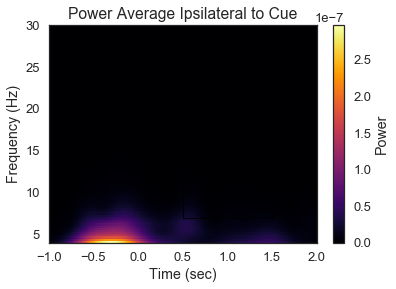

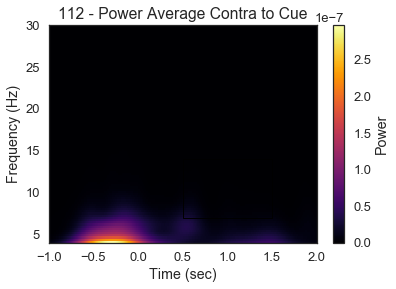

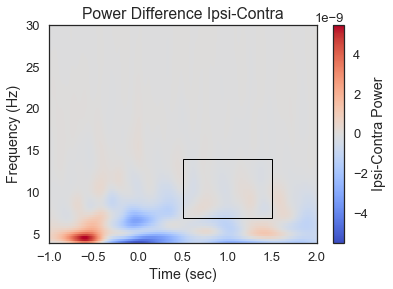

In [76]:
subs = [101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112]
sub_count = 1
diff_out = []
for sub in subs:
    print(sub)
    frequencies =  np.linspace(4, 30, 100, endpoint=True)
    wave_cycles = 6

    # Load both sessions
    raw = utils.load_data('visual/cueing', sfreq=256., 
                          subject_nb=sub, session_nb=1)
    raw.append(    utils.load_data('visual/cueing', sfreq=256., 
                          subject_nb=sub, session_nb=2)           )

    # Filter Raw Data
    raw.filter(1,30, method='iir')

    #Select Events
    events = find_events(raw)
    event_id = {'LeftCue': 1, 'RightCue': 2}
    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=-1, tmax=2, baseline=(-1, 0), 
                    reject={'eeg':.06}, preload=True,
                    verbose=False, picks=[0, 1, 2, 3])
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    # Compute morlet wavelet

    # Left Cue
    tfr, itc = tfr_morlet(epochs['LeftCue'], freqs=frequencies, 
                          n_cycles=wave_cycles, return_itc=True)
    #tfr.plot(picks=[0], mode='logratio', 
    #         title='TP9 - Ipsi');
    #tfr.plot(picks=[3], mode='logratio', 
    #         title='TP10 - Contra');
    power_Ipsi_TP9 = tfr.data[0,:,:]
    power_Contra_TP10 = tfr.data[3,:,:]

    # Right Cue
    tfr, itc = tfr_morlet(epochs['RightCue'], freqs=frequencies, 
                          n_cycles=wave_cycles, return_itc=True)
    #tfr.plot(picks=[0], mode='logratio', 
    #         title='TP9 - Contra');
    #tfr.plot(picks=[3], mode='logratio', 
    #         title='TP10 - Ipsi');
    power_Contra_TP9 = tfr.data[0,:,:]
    power_Ipsi_TP10 = tfr.data[3,:,:]

    # Plot Differences
    %matplotlib inline
    times = epochs.times
    power_Avg_Ipsi =   (power_Ipsi_TP9+power_Ipsi_TP10)/2;
    power_Avg_Contra = (power_Contra_TP9+power_Contra_TP10)/2;
    power_Avg_Diff = power_Avg_Ipsi-power_Avg_Contra;


    #find max to make color range
    plot_max = np.max([np.max(np.abs(power_Avg_Ipsi)), np.max(np.abs(power_Avg_Contra))])
    plot_diff_max = np.max(np.abs(power_Avg_Diff))

    #Ipsi
    fig, ax = plt.subplots(1)
    im = plt.imshow(power_Avg_Ipsi,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='inferno', vmin=0, vmax=plot_max)
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Power Average Ipsilateral to Cue')
    cb = fig.colorbar(im)
    cb.set_label('Power')
    # Create a Rectangle patch
    rect = patches.Rectangle((.5,7),1,7,linewidth=1,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

    #TP10
    fig, ax = plt.subplots(1)
    im = plt.imshow(power_Avg_Contra,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='inferno', vmin=0, vmax=plot_max)
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.title(str(sub) + ' - Power Average Contra to Cue')
    cb = fig.colorbar(im)
    cb.set_label('Power')
    # Create a Rectangle patch
    rect = patches.Rectangle((.5,7),1,7,linewidth=1,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

    #difference between conditions
    fig, ax = plt.subplots(1)
    im = plt.imshow(power_Avg_Diff,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_diff_max, vmax=plot_diff_max)
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Power Difference Ipsi-Contra')
    cb = fig.colorbar(im)
    cb.set_label('Ipsi-Contra Power')
    # Create a Rectangle patch
    rect = patches.Rectangle((.5,7),1,7,linewidth=1,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
     
    #output data into array    
    diff_out.append(np.mean(power_Avg_Diff[np.argmax(frequencies>7):np.argmax(frequencies>14)-1,
                            np.argmax(times>0):np.argmax(times>1.5)-1 ])
                   )



In [77]:
    
    print(diff_out)
    

[-1.901486365186678e-11, 3.2478484215983596e-11, 4.131335523555978e-11, 6.067640967351224e-11, -5.756678314485149e-11, -2.3356452837021003e-11, 2.739872694123598e-11, 2.861155470409003e-11, 1.5005140157320852e-10, -2.1613801777494358e-11, -1.718497046640483e-10]
